<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Требуется:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в таблице `taxi`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer, root_mean_squared_error

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
)
from sklearn.compose import ColumnTransformer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv')
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [3]:
taxi.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Проверим количество пропусков

In [5]:
taxi.isna().sum()

datetime      0
num_orders    0
dtype: int64

Проверим количество дубликатов

In [6]:
taxi.duplicated().sum()

0

Сделаем дату и время индексом таблицы, отсортируем таблицу по индексам.

In [7]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi = taxi.set_index('datetime')
taxi.sort_index(inplace=True)

Проведем ресемплирование по одному часу

In [8]:
taxi = taxi.resample('1h').sum()

In [9]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:** 

Данные загружены, проверены на пропуски и дубликаты, столбец `datetime` получил тип данных datetime и стал индексом таблицы. Проведено ресемплирование по одному часу.

## Анализ

Посмотрим на общий график вызовов такси.

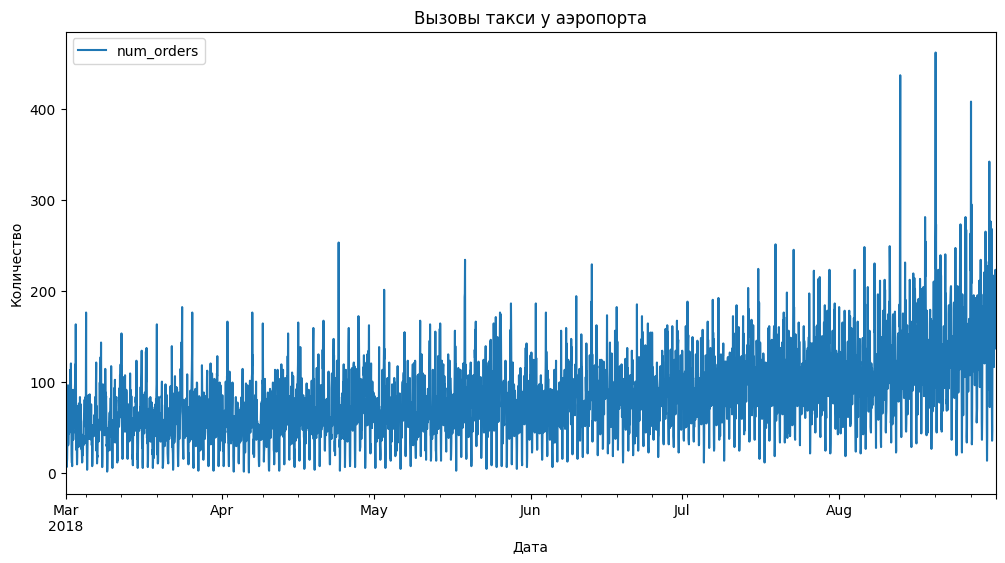

In [10]:
taxi.plot(
    figsize=(12, 6),
    title='Вызовы такси у аэропорта',
    xlabel='Дата',
    ylabel='Количество'
);

Данный ряд является стационарным.

In [11]:
taxi = taxi.dropna()

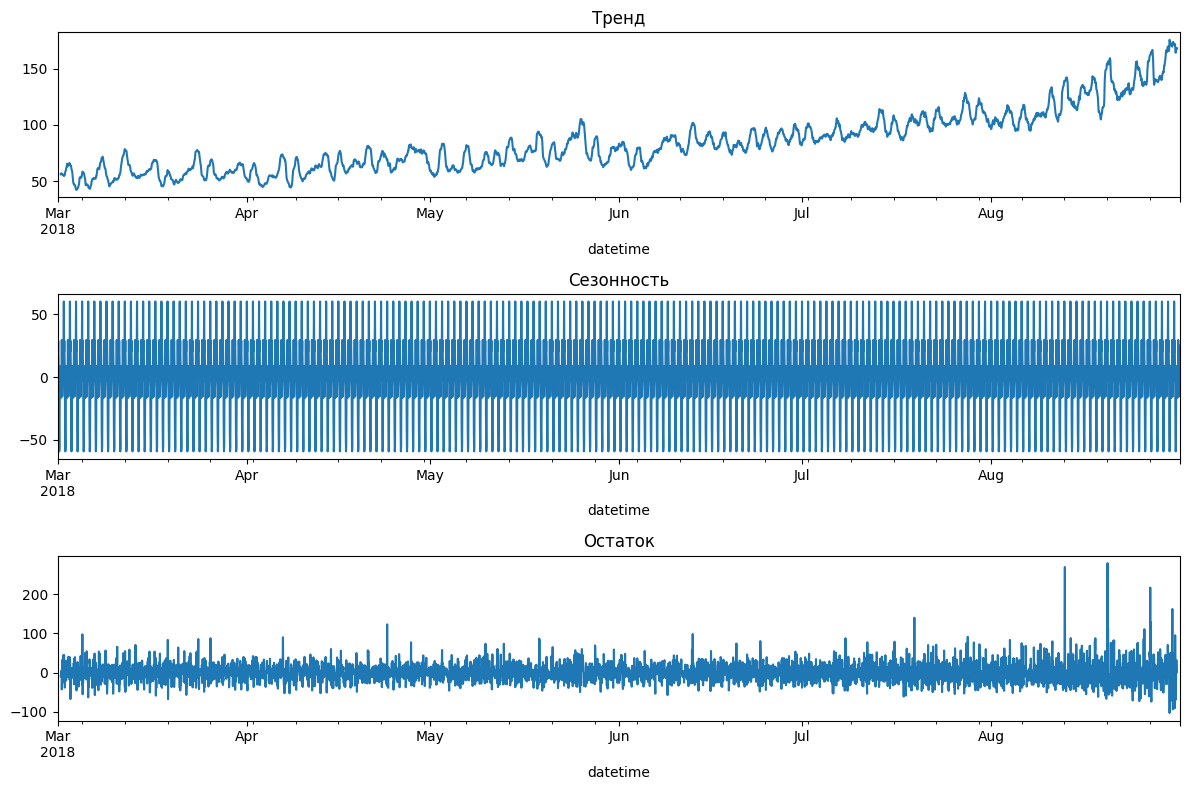

In [12]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')

plt.tight_layout()

Рассмотрим сезонность поближе

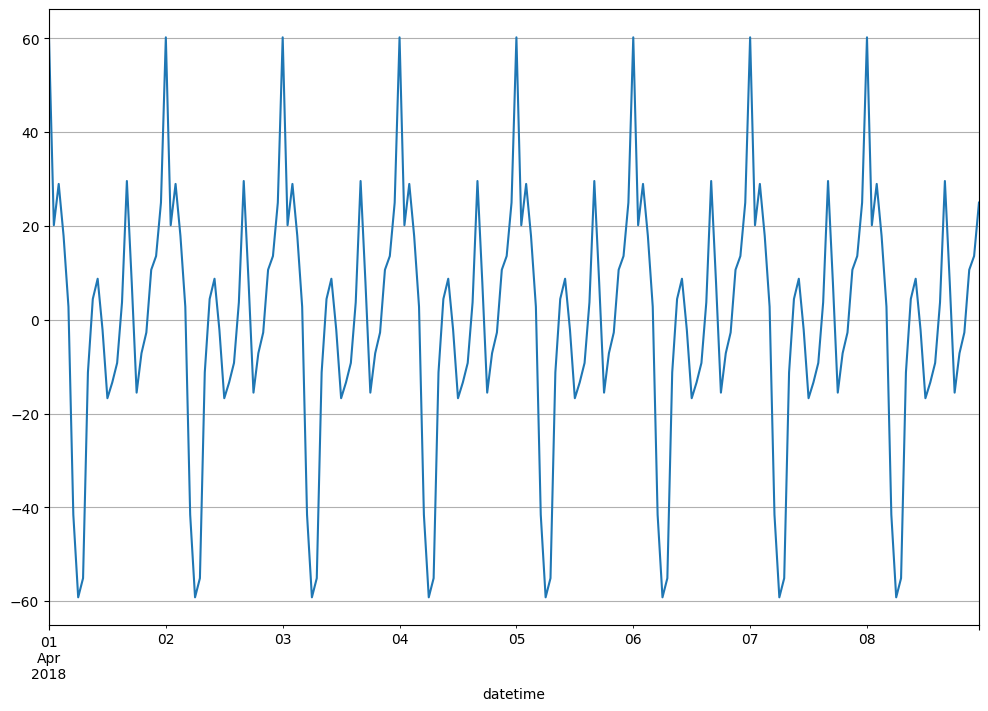

In [13]:
plt.figure(figsize=(12, 8))
decomposed.seasonal['2018-04-01':'2018-04-08'].plot(grid=True);

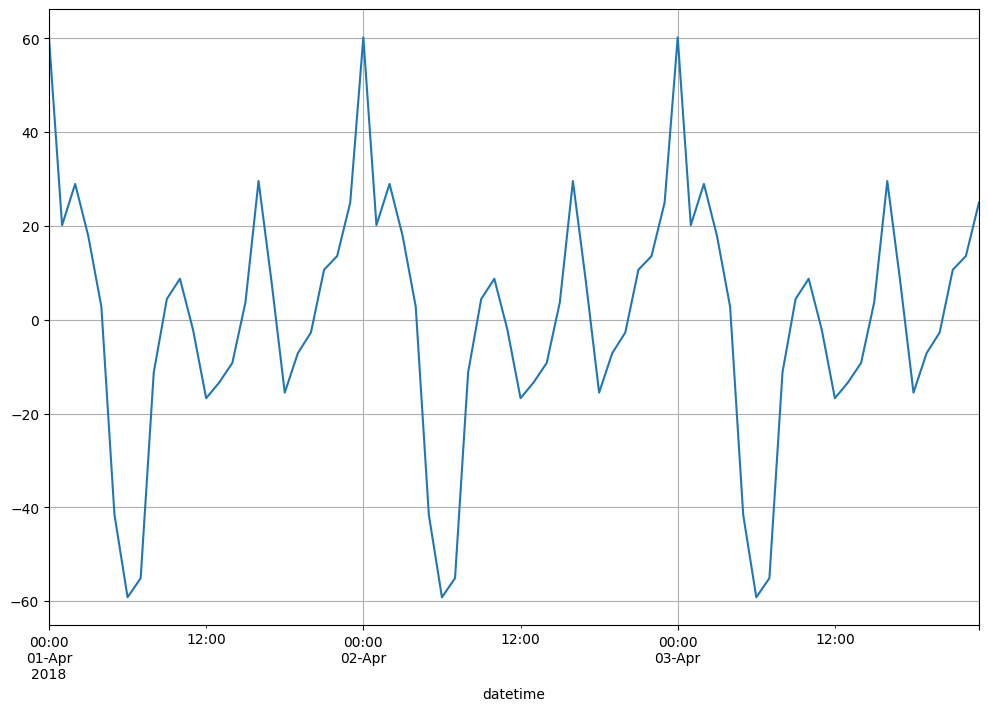

In [14]:
plt.figure(figsize=(12, 8))
decomposed.seasonal['2018-04-01':'2018-04-03'].plot(grid=True);

Пик заказов такси в аэропортах бывает примерно в 12 часов вечера. Самое небольшое количество - в 6 утра.

## Обучение

Проведем анализ автокорреляции, который позволит определить оптимальное количество лагов и размер окна

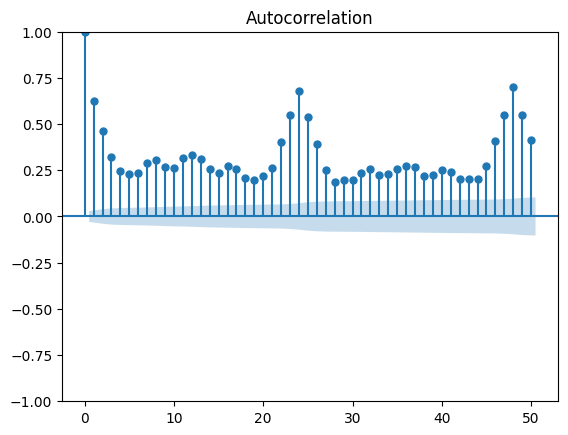

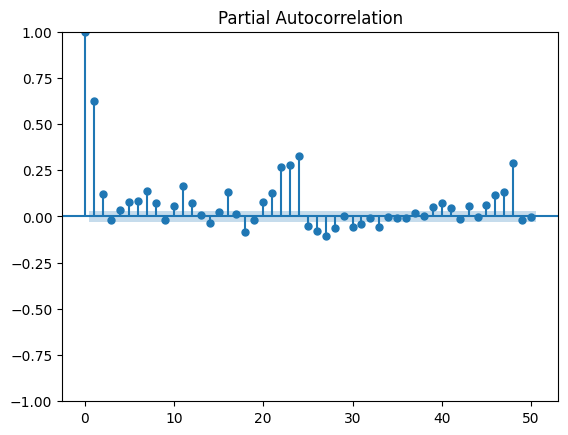

In [15]:
plot_acf(taxi['num_orders'], lags=50)
plot_pacf(taxi['num_orders'], lags=50)
plt.show()

Добавим в таблицу признаки: день недели, отстающие значения (до 24) и скользящее среднее (размер окна 1).

In [16]:
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour
for lag in range(1, 25):
    taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(1).mean()

In [17]:
taxi = taxi.dropna()
taxi

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.0
2018-03-02 01:00:00,120,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,90.0
2018-03-02 02:00:00,75,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,120.0
2018-03-02 03:00:00,64,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,75.0
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,207.0
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,136.0
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,154.0


Разделим данные на обучающую и тестовую выборки.

In [18]:
train, test = train_test_split(
    taxi,
    shuffle=False,
    test_size=0.1
)
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']


In [19]:
pipe_final = Pipeline([
    ('model', LinearRegression())
])

In [20]:
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=12345)],
        'model__max_depth': range(3, 7),
        'model__max_features': range(5, 9),
        'model__min_samples_split': range(2, 7),
        'model__min_samples_leaf': range(1, 7),
    },
    {
        'model': [LinearRegression()],
    }
]

In [21]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [22]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [DecisionTreeRegressor(random_state=12345)],
                          'model__max_depth': range(3, 7),
                          'model__max_features': range(5, 9),
                          'model__min_samples_leaf': range(1, 7),
                          'model__min_samples_split': range(2, 7)},
                         {'model': [LinearRegression()]}],
             scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [23]:
cv_results = grid_search.cv_results_
cv_results = pd.DataFrame(cv_results)
best_model = grid_search.best_estimator_
print(cv_results[['mean_test_score', 'std_test_score', 'mean_fit_time']])

print(f'Лучшая модель: {grid_search.best_params_}')
print(f'Лучший результат (RMSE): {grid_search.best_score_}')

     mean_test_score  std_test_score  mean_fit_time
0         -35.703192        5.319875       0.008028
1         -35.703192        5.319875       0.006627
2         -35.703192        5.319875       0.008944
3         -35.703192        5.319875       0.009819
4         -35.703192        5.319875       0.005875
..               ...             ...            ...
476       -28.799520        5.963610       0.008953
477       -28.799520        5.963610       0.008462
478       -28.799520        5.963610       0.008570
479       -28.799520        5.963610       0.008422
480       -25.884308        3.952629       0.003486

[481 rows x 3 columns]
Лучшая модель: {'model': LinearRegression()}
Лучший результат (RMSE): -25.88430789384571


Были обучены модели LinearRegression и DecisionTreeRegressor с различными гиперпараметрами. Модель LinearRegression стала лучшей.

## Тестирование

Проверим качество модели LinearRegression на тестовой выборке

In [24]:
y_pred = best_model.predict(X_test)

In [25]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Лучший RMSE: {rmse:.4f}")

Лучший RMSE: 45.2241


**Вывод:** Условие выполняется, RMSE < 48. Данный результат был достигнут благодаря увеличению отстающих значений (lag feauters) до 24.

## Выводы

Результаты:
- Данные загружены, проверены на пропуски и дубликаты, столбец `datetime` получил тип данных datetime и стал индексом таблицы. Проведено ресемплирование по одному часу.
- Анализ показал: пик заказов такси в аэропортах бывает примерно в 12 часов вечера. Самое небольшое количество - в 6 утра.
- Были обучены модели LinearRegression и DecisionTreeRegressor с различными гиперпараметрами. Модель LinearRegression стала лучшей.
- Тестирование показало, что условие выполняется, RMSE < 48. Данный результат был достигнут благодаря увеличению отстающих значений (lag feauters) до 24.

Обученная модель линейное регрессии позволит бизнесу точно понимать спрос на такси в аэропортах в определенные часы, что в дальнейшем приведет к повышению прибыли, если грамотно распределить количество таксистов в определенное время.